In [0]:
import pyspark
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pyspark.sql.functions import to_timestamp, date_format

rdd = sc.textFile('s3a://msds-694-groupproject-21/data/COVID-19_Case_Surveillance_Public_Use_Data.csv')

## Goals
- Our primary goal is to investigate the impact of Covid-19 policies on the number of Covid
cases and deaths.
- Specifically, we aim to analyze the trends in cases and deaths over time, considering the
implementation of different policies such as quarantine, vaccination campaigns, and the
development of a cure.

## Data:
- Our data is COVID-19 Case Surveillance dataset. It is compiled and maintained by the
Centers for Disease Control and Prevention (CDC), and it is a comprehensive collection of
information related to individuals affected by the COVID-19 virus.
- It has 101766480 rows and 14 columns. It contains the following information:
  - Reporting Dates:
    - cdc_report_dt: Date when a case was first reported to the CDC.
    - cdc_case_earliest_dt: The earliest date related to illness or specimen collection.
  - Clinical Information:
    - pos_spec_dt: Date of the first positive specimen collection.
    - onset_dt: Date of symptom onset.
  - Individual Details:
    - current_status: Indicates if the case is a laboratory-confirmed or probable case.
    - sex: Gender of the individual.
    - age_group: Categorization of age groups.
    - race_ethnicity_combined: Combined information on race and ethnicity.
  - Health Status and Outcomes:
    - hosp_yn: Whether the patient was hospitalized.
    - icu_yn: Whether the patient was admitted to an intensive care unit (ICU).
    - death_yn: Indicates if the patient died as a result of the illness.
    - medcond_yn: Indicates pre-existing medical conditions.

- We will focus on 5 columns: cdc_case_earliest_dt, hosp_yn, death_yn, medcond_yn. We also
transformed them to get a better analysis as follows:
  - Convert the 'cdc_case_earliest_dt' column into datetime values where we can track the year and month of case reports.
  - Calculate the total death counts due to COVID-19 among individuals during this time period.
  - Calculate the death rates of positive cases of COVID-19 throughout the time period.
  - Track the total hospitalizations of individuals as a result of COVID-19 throughout this time period.
  - Calculate the death rate due to COVID-19 for individuals with pre-existing medical conditions by obtaining the ratio of
  'medcond_yn' against 'death_yn'.
  - Group certain columns by "yes" or "no" to observe the differences.

- Assumptions and Data Cleaning
  - For the missing values and unknown values, we chose to drop them because we would have enough information with our existing data.

## Significant Dates:
- Using information from the CDC Museum COVID-19 Timeline website, we identified three important dates throughout the history of COVID-19 that may have had a significant impact. The dates we identified are:
  - Stay at Home Mandate enforced (US) - 2020/3/14
  - Vaccine Release - 2020/12/14
  - Vaccine Boosters Release and Recommendation - 2021/12/9

- While these do not encompass all important milestones in the mitigation of COVID-19, we believe they could be some of the most impactful.

- CDC Museum COVID-19 Timeline https://www.cdc.gov/museum/timeline/covid19.html

## Insights:
- Analyzing the data in this way will give us the opportunity to assess the following factors that could impact response and survival rates in any future pandemics.
  - Temporal Trends:
  - Analyze the temporal trends in the number of reported COVID-19 cases and deaths
over time.
  - Identify peaks and valleys in the data to understand the progression of the pandemic.
  - Policy Impact Assessment:
    - Evaluate the impact of key public health policies on the trends in cases and death
    - Explore how these policies correlate with changes in the spread and severity of the virus

In [0]:
def convert_to_datetime(info):
	try:
		date = '-'.join((info[0].split('/'))[:2])
		date = datetime.strptime(date, '%Y-%m')
		info[0] = date
		return info
	except:
		info[0] = 0
		return info

In [0]:
# split rdd
split_rdd = rdd.map(lambda x: x.split(','))

# convert the first column to datetime values
dtime_rdd = split_rdd.map(convert_to_datetime)

# remove rows where the first column is empty
filtered_rdd = dtime_rdd.filter(lambda x: x[0] != 0)

# create rdd with only dates and Case status
ym_case_rdd = filtered_rdd.map(lambda x: (x[0], x[4]))

# sort by datetime and then get counts by month
ym_case_rdd = ym_case_rdd.sortByKey()
ym_case_counts = ym_case_rdd.countByValue()

In [0]:
# separate cases by Laboratory Confirmed and Probable Cases
lab_confirmed_cases = ym_case_rdd.filter(lambda x: x[1] == 'Laboratory-confirmed case')
probable_cases = ym_case_rdd.filter(lambda x: x[1] == 'Probable Case')

In [0]:
# Create Dataframe for plotting with Lab confirmed counts
lab_conf_df = pd.DataFrame.from_dict(lab_confirmed_cases.countByKey(), orient='index')
lab_conf_df.columns = ['Case Count']

In [0]:
# Create Dataframe for plotting with Probable Case counts
prob_case_df = pd.DataFrame.from_dict(probable_cases.countByKey(), orient='index')
prob_case_df.columns = ['Case Count']

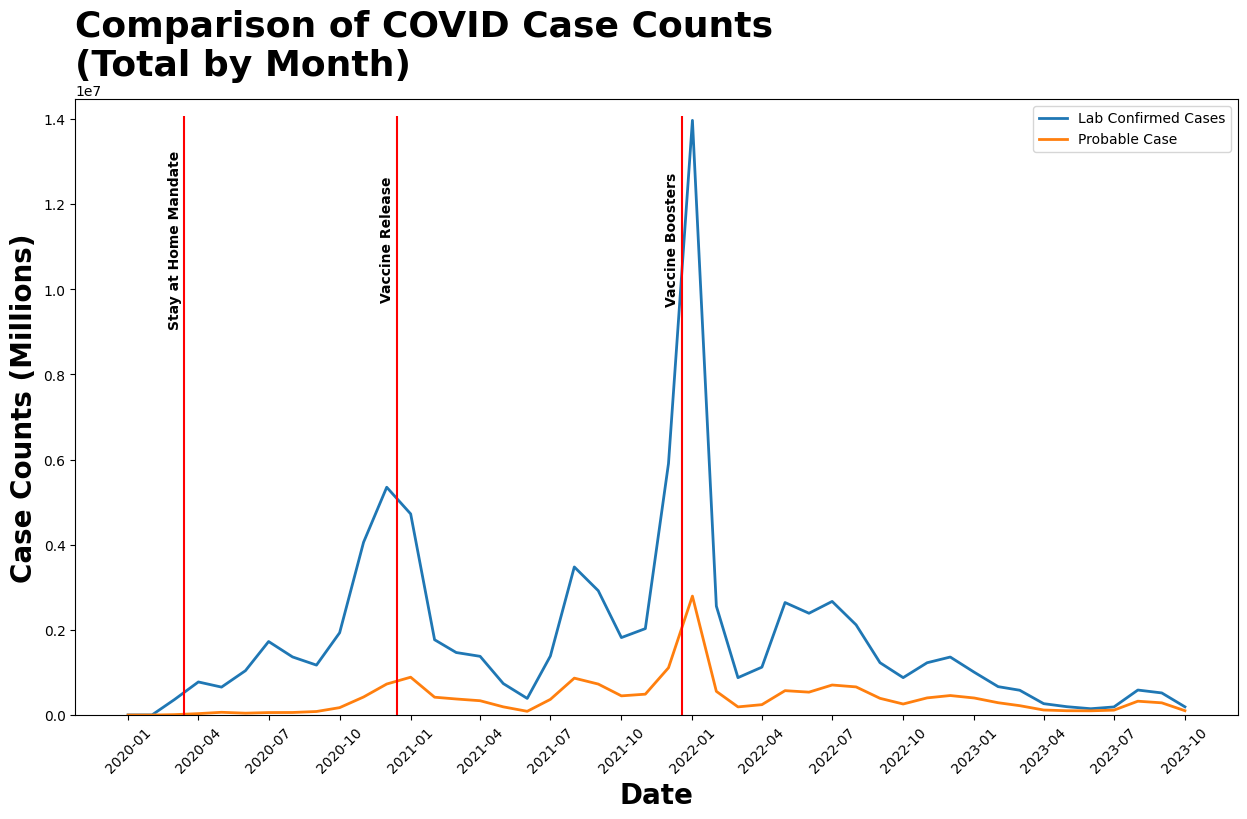

In [0]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(lab_conf_df, label='Lab Confirmed Cases', linewidth=2)
ax.plot(prob_case_df, label='Probable Case', linewidth=2)

#ax.set_title('Comparison of Lab Confirmed Cases to Probable Cases\n(Total Count by Month)')
plt.title(label='Comparison of COVID Case Counts\n(Total by Month)',
		  fontdict={'size': 26, 'weight':'bold'}, loc='left')
plt.ylabel('Case Counts (Millions)', fontdict={'size': 20, 'weight':'bold'})
plt.xlabel('Date', fontdict={'size': 20, 'weight':'bold'})

ax.vlines(x=datetime(2020, 3, 14), ymin=0, ymax=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) + 100000,
		  colors='red')
ax.text(s='Stay at Home Mandate', x=datetime(2020, 3, 11), 
		y=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2020, 12, 14), ymin=0, ymax=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) + 100000,
		  colors='red')
ax.text(s='Vaccine Release', x=datetime(2020, 12, 10), 
		y=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2021, 12, 19), ymin=0, ymax=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) + 100000,
		  colors='red')
ax.text(s='Vaccine Boosters', x=datetime(2021, 12, 14), 
		y=max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ind = np.arange(0, len(lab_conf_df), 3)
# ind = np.arange(2, len(lab_conf_df), 3)
# ind = np.insert(ind, 0, 0)
new_ind = [datetime.strftime(lab_conf_df.index[num], '%Y-%m') for num in ind]
ax.set_xticks(new_ind)
ax.set_xticklabels(new_ind)

ax.set_ylim(0, max(max(lab_conf_df['Case Count']), max(prob_case_df['Case Count'])) + 500000)

plt.legend()
plt.xticks(rotation=45)

plt.show()

### Insights
Looking at the trends, we see that the vaccine releases appear to have significant and near immediate impact on limiting COVID-19 deaths. Althought the development and deployment of a vaccine on a large scale is not an easy task, we can see here that it should be a priority in future pandemics to help limit the loss of life and health impact of a pandemic.

In [0]:
# remove unknown and missing values for hospitalized column
prcsd_rdd = filtered_rdd.filter(lambda row:row[10] not in ['Unknown','Missing'])

In [0]:
# separate rdd into hospitalized and not hospitalized cases

prcsd_rdd = filtered_rdd.filter(lambda row:row[10] not in ['Unknown','Missing'])

# separate rdd into hospitalized and not hospitalized cases
not_hospitalized_rdd = prcsd_rdd.filter(lambda row: row[10] == 'No').map(lambda row: (row[0], row[10]))
hospitalized_rdd = prcsd_rdd.filter(lambda row: row[10] == 'Yes').map(lambda row: (row[0], row[10]))

# Sort by year and month and counts by value for each month
hospitalized_dt = hospitalized_rdd.sortByKey()
hospitalized_counts = hospitalized_dt.countByKey()

not_hospitalized_dt = not_hospitalized_rdd.sortByKey()
not_hospitalized_counts = not_hospitalized_dt.countByKey()

# Create dataframes for plotting
hosp_df = pd.DataFrame.from_dict(hospitalized_counts, orient='index')
hosp_df.columns = ['Case Count']

not_hosp_df = pd.DataFrame.from_dict(not_hospitalized_counts, orient='index')
not_hosp_df.columns = ['Case Count']

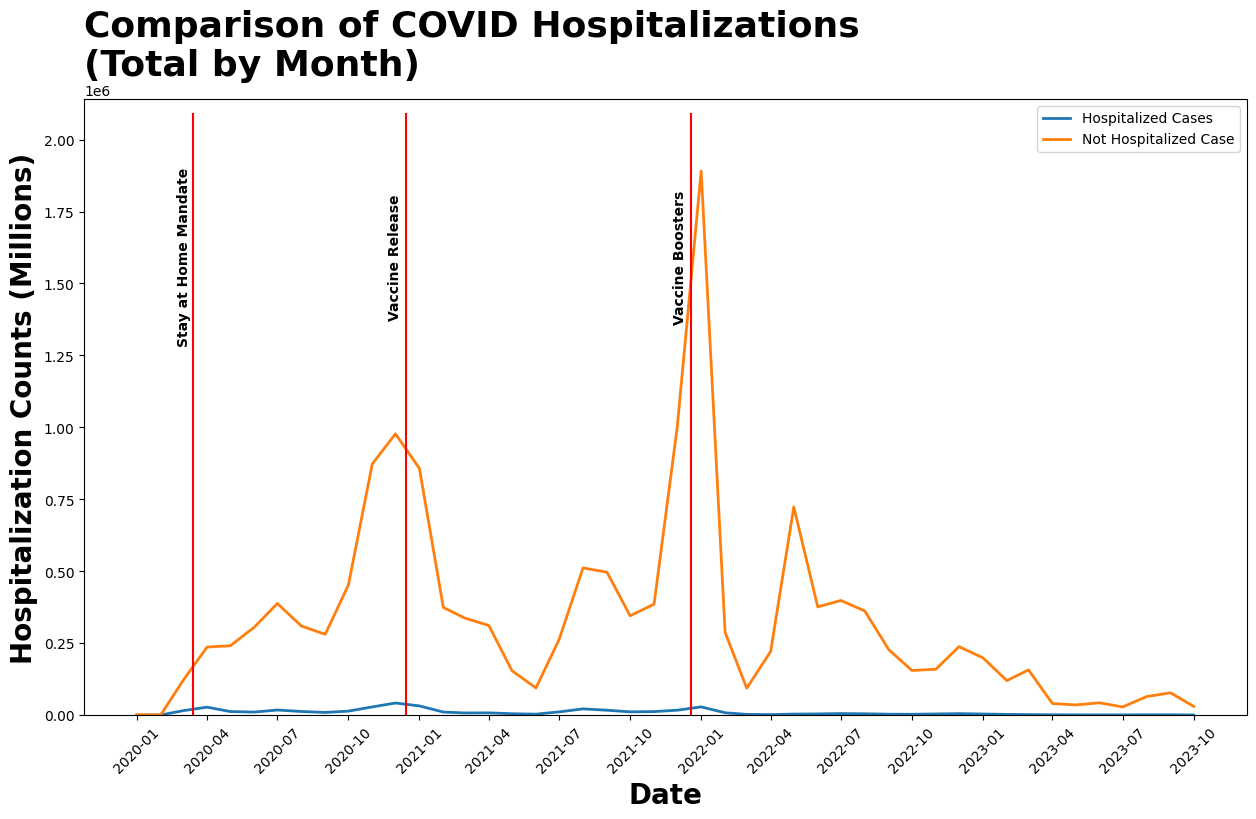

In [0]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(hosp_df, label='Hospitalized Cases', linewidth=2)
ax.plot(not_hosp_df, label='Not Hospitalized Case', linewidth=2)

plt.title(label='Comparison of COVID Hospitalizations\n(Total by Month)',
		  fontdict={'size': 26, 'weight':'bold'}, loc='left')
plt.ylabel('Hospitalization Counts (Millions)', fontdict={'size': 20, 'weight':'bold'})
plt.xlabel('Date', fontdict={'size': 20, 'weight':'bold'})

ax.vlines(x=datetime(2020, 3, 14), ymin=0, ymax=max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 200000,
		  colors='red')
ax.text(s='Stay at Home Mandate', x=datetime(2020, 3, 11), 
		y=(max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 100000) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2020, 12, 14), ymin=0, ymax=max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 200000,
		  colors='red')
ax.text(s='Vaccine Release', x=datetime(2020, 12, 10), 
		y=(max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 100000) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2021, 12, 19), ymin=0, ymax=max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 200000,
		  colors='red')
ax.text(s='Vaccine Boosters', x=datetime(2021, 12, 14), 
		y=(max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 100000) / 1.25,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ind = np.arange(0, len(not_hosp_df), 3)
new_ind = [datetime.strftime(not_hosp_df.index[num], '%Y-%m') for num in ind]
ax.set_xticks(new_ind)
ax.set_xticklabels(new_ind)

ax.set_ylim(0, max(max(not_hosp_df['Case Count']), max(hosp_df['Case Count'])) + 250000)

plt.legend()
plt.xticks(rotation=45)

plt.show()


### Insights
Similar to the impact of the vaccines on the overall counts death toll of the COVID-19 pandemic, we see that the hospitalization rates of COVID-19 decreased dramatically after the deployment of the vaccine and the boosters. This is another strong vote of confidence in favor of vaccinating at a large scale to mitigate the impact of a pandemic.

# Getting Death Rates/Counts

In [0]:
def convert_to_year_month(row):
    date_string, value = row
    if value == 'Yes':
        value = 1
    elif value == 'No':
        value = 0
    return [date_string, value]

In [0]:
death_rdd = filtered_rdd.map(lambda x: (x[0],x[-2]))

# sort the rdd by year and month
dd = death_rdd.filter(lambda x:x[1]=='Yes' or x[1]== 'No')

#get the data from rdd
monthly = dd.map(convert_to_year_month).groupByKey().map(lambda x: [x[0], sum(x[1]) / len(list(x[1]))]).collect()

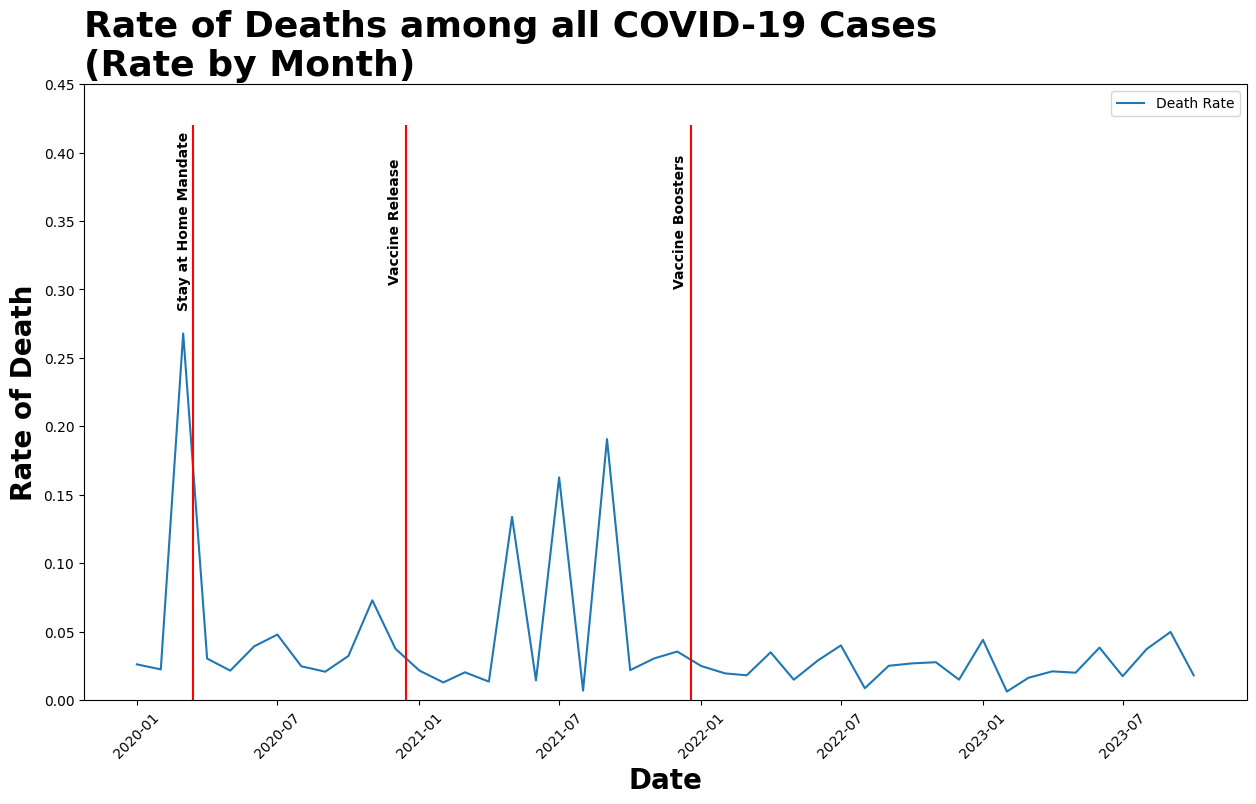

In [0]:
fig, ax = plt.subplots(figsize=(15,8))

# Get dates array
dates = np.array(monthly)[:,0]
dates = [pd.to_datetime(date, format='%Y/%m').tz_localize(None) for date in dates] # .tz_localize(None) might not necessary

plt.title(label='Rate of Deaths among all COVID-19 Cases\n(Rate by Month)',
		  fontdict={'size': 26, 'weight':'bold'}, loc='left')
plt.ylabel('Rate of Death', fontdict={'size': 20, 'weight':'bold'})
plt.xlabel('Date', fontdict={'size': 20, 'weight':'bold'})

# Sort dates
dates = sorted(dates)

# Get y-values (death rates)
y = np.array(monthly)[:,1].astype(float)

ax.plot(dates, y, label='Death Rate')

# Highlight specific dates
ax.vlines(x=datetime(2020, 3, 14), ymin=0, ymax=.42,
		  colors='red')
ax.text(s='Stay at Home Mandate', x=datetime(2020, 3, 11), 
		y=0.35,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2020, 12, 14), ymin=0, ymax=.42,
		  colors='red')
ax.text(s='Vaccine Release', x=datetime(2020, 12, 10), 
		y=0.35,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2021, 12, 19), ymin=0, ymax=.42,
		  colors='red')
ax.text(s='Vaccine Boosters', x=datetime(2021, 12, 14), 
		y=0.35,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.set_ylim(0, 0.45)

# Set x-axis to show only the selected dates
selected_dates = pd.date_range(start=dates[0], end=dates[-1], periods=10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better readability
plt.xticks(rotation=45)

plt.legend()
plt.show()


### Insights
There do not appear to be any clear or actionable insights in terms of mitigating the overall death rate among COVID-19 cases, however, given the fact that we see the highest rate at the beginning of the pandemic, it suggests that patients and doctors were not as well suited to handle the virus given the relative lack of information at that point. One other potential insight we may find is that the spikes in mid-2021 may have come from individuals placing too much belief in the effectiveness of the vaccine at fully preventing COVID-19. The virus was still widespread at that point, and, while vaccinated, individuals should have remained wary of the possibility of catching a dangerous disease.

# Pre-Existing Medical Condition Rates

In [0]:
def month_difference(date1, date2):
    year_diff = date1.year - date2.year
    month_diff = date1.month - date2.month
    return year_diff * 12 + month_diff + 1

def add_month_diff_column(row):
    cdc_report_dt = row[1]
    earliest_report_dt = row[0]
    month_diff = month_difference(cdc_report_dt, earliest_report_dt)
    return row + [month_diff]

med_con_rdd = filtered_rdd.filter(lambda row: row[-2] in {'Yes', 'No'} and row[-3] in {'Yes', 'No'})


In [0]:
def compute_rate(values):
    total = len(values)
    with_condition = sum(1 for v in values if v == 'Yes')
    return with_condition / total if total != 0 else 0

grouped_medcon_rdd = med_con_rdd.filter(lambda row: row[-3] == 'Yes').map(lambda row: (row[0], row[-2]))
med_rate_rdd = grouped_medcon_rdd.groupByKey().mapValues(compute_rate)

rate_dict = med_rate_rdd.collectAsMap()

# create x and y columns for plotting
plot_x = dates
plot_y = []
for k, v in rate_dict.items():
    plot_y.append(v)

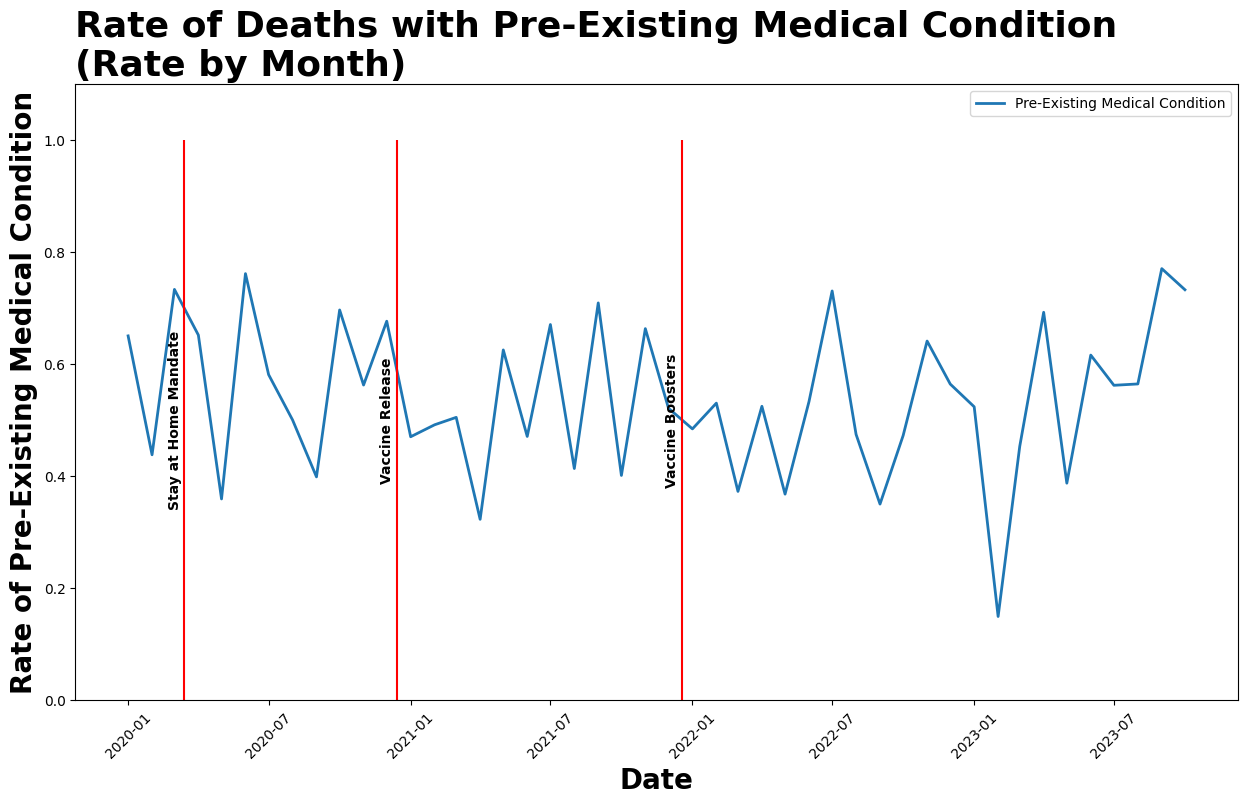

In [0]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(plot_x, plot_y, label='Pre-Existing Medical Condition', linewidth=2)

#ax.set_title('Comparison of Lab Confirmed Cases to Probable Cases\n(Total Count by Month)')
plt.title(label='Rate of Deaths with Pre-Existing Medical Condition\n(Rate by Month)',
		  fontdict={'size': 26, 'weight':'bold'}, loc='left')
plt.ylabel('Rate of Pre-Existing Medical Condition', fontdict={'size': 20, 'weight':'bold'})
plt.xlabel('Date', fontdict={'size': 20, 'weight':'bold'})

ax.vlines(x=datetime(2020, 3, 14), ymin=0, ymax=1,
		  colors='red')
ax.text(s='Stay at Home Mandate', x=datetime(2020, 3, 11), 
		y=0.5,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2020, 12, 14), ymin=0, ymax=1,
		  colors='red')
ax.text(s='Vaccine Release', x=datetime(2020, 12, 10), 
		y=0.5,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

ax.vlines(x=datetime(2021, 12, 19), ymin=0, ymax=1,
		  colors='red')
ax.text(s='Vaccine Boosters', x=datetime(2021, 12, 14), 
		y=0.5,
		verticalalignment='center', rotation='vertical',
		horizontalalignment='right', weight='bold')

# Set x-axis to show only the selected dates
selected_dates = pd.date_range(start=dates[0], end=dates[-1], periods=10)
#plt.gca().xaxis.set_major_locator(mdates.DateLocator(selected_dates))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better readability
plt.xticks(rotation=45)

ax.set_ylim(0, 1.1)

plt.legend()

plt.show()

### Insights
Although there do not appear to be any immediate or obvious responses in terms of how to prevent further loss of life as a result of a pandemic like COVID-19 among individuals with pre-existing medical conditions. This chart proves that the emphasis for proper and prioritized care needs to be placed on individuals who exhibit higher risk of death as a result of having pre-existing medical conditions. We see the major milestones that had noticeable impact on the death count, death rate, and hospitalization counts resulting from COVID-19 had little or no impact on the death rate among individuals with pre-existing medical conditions. Moving forward, we should remember to emphasize caring for these individuals.